## Goal

06/10/2022

Find a okay heuristics to filter for variants with expected two-state activity.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py

from nnn import dG_fit

In [2]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.075)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                    )
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file=annotation_file)

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
39.48% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [3]:
rep = arraydata.get_replicate_data('r2')
xdata, curve, curve_se = arraydata.get_replicate_curves('r2')

xdata.shape, curve.shape

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


((17,), (27745, 17))

## Can we filter out with simple heuristics?

Such as the normalized fluorescence at 20°C

<AxesSubplot:xlabel='Green12_20.0_norm', ylabel='Green28_60.0_norm'>

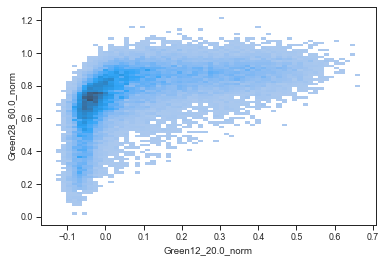

In [4]:
sns.histplot(x=curve.iloc[:,0], y=curve.iloc[:,-1])

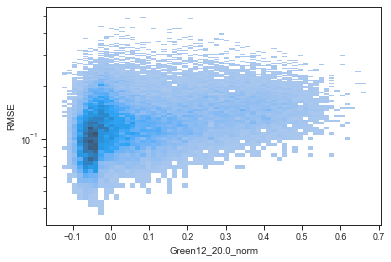

In [5]:
sns.histplot(data=rep, x='Green12_20.0_norm', y='RMSE')
plt.yscale('log')


### Conclusion

The relationship between the coldest and hottest point makes total sense and I shouldn't filter out constructs based on that.
I don't see a clear trend between starting point and fitting quality.
It may not be a good idea to filter with such quick and dirty criteria.

## The dG line

Find dG as a function of temperature and evaluate if it falls on a line, aka two state.

### Testing on single datapoints


In [4]:
from sklearn import linear_model
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
import lmfit

In [5]:
%%time
# Calculate dG
# Propagation of uncertainties

epsilon = 1e-2
fmax = rep.fmax.values.reshape(-1, 1)+ epsilon
fmin = rep.fmin.values.reshape(-1, 1)- epsilon
curve_norm = np.clip((curve - fmin) / (fmax - fmin),
                    a_min=epsilon, a_max=1-epsilon)
dG = -kB * xdata.reshape(1,-1) * np.log(1/curve_norm - 1)
curve_norm_se = curve_se.values / (rep.fmax - rep.fmin).values.reshape(-1, 1)
curve_norm_uarray = unumpy.uarray(curve_norm, curve_norm_se)
dG_uarray = -kB * xdata.reshape(1,-1) * unumpy.log(1/curve_norm_uarray - 1)
# dG = unumpy.nominal_values(dG_uarray)
dG_se_arr = unumpy.std_devs(dG_uarray)
dG_se = pd.DataFrame(data=dG_se_arr, index=dG.index, columns=dG.columns)

CPU times: user 9.48 s, sys: 236 ms, total: 9.71 s
Wall time: 9.74 s


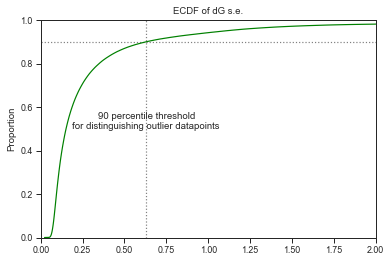

In [825]:
# sns.histplot(dG_se.values.flatten(), bins=np.arange(0,2,0.05), kde=False)
perc = 90
plt.axvline(np.percentile(dG_se.values.flatten(), perc), color='gray', linestyle=':')
plt.axhline(perc/100, color='gray', linestyle=':')
plt.text(np.percentile(dG_se.values.flatten(), perc), .5, '%d percentile threshold\nfor distinguishing outlier datapoints'%perc, ha='center')
sns.ecdfplot(dG_se.values.flatten(), color='g')
plt.xlim([0,2])

plt.title('ECDF of dG s.e.')
util.save_fig('./fig/alternative_fitting/z_ECDF_dG_se.pdf')

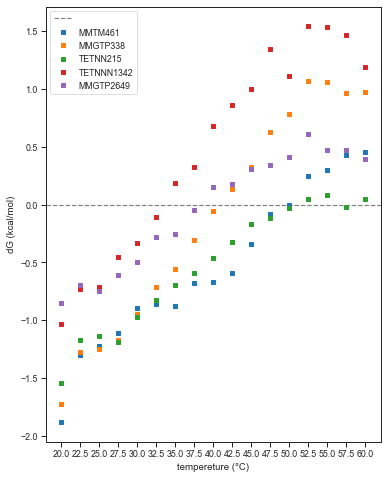

In [826]:
# plot some dG of randomly sampled variants

n = 5
fig, ax = plt.subplots(figsize=(6,8))
sample = dG.sample(5).T
plt.axhline(y=0, color='gray', linestyle='--')
plt.plot(sample, 's')
plt.xticks(np.arange(17), xdata - C2T)
plt.xlabel('tempereture (°C)')
plt.ylabel('dG (kcal/mol)')
plt.legend(['']+sample.columns.tolist())

util.save_fig('./fig/alternative_fitting/z_example_dG.pdf')
plt.show()

In [6]:
# fit with RANSAC
def add_intercept(arr):
    arr_colvec = arr.reshape(-1, 1)
    return np.concatenate((arr_colvec, np.ones_like(arr_colvec)), axis=1)

f_margin = 0.025

function = lambda dH, Tm, fmax, fmin, x: fmin + (fmax - fmin) / (1 + np.exp(dH/kB*((Tm+273.15)**-1 - x**-1)))
yerr_thresh = np.percentile(dG_se.values.flatten(), perc)
y = dG.sample()
# y = dG.loc[['TETNNN3629'], :]
yerr = dG_se.loc[y.index, :].values.flatten()
row = rep.loc[y.index, :]
ycurve = curve.loc[y.index, :].values.flatten()
ycurve_norm = curve_norm.loc[y.index, :].values.flatten()

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(xdata.reshape(-1,1), y.values.reshape(-1,1))
# inlier_mask = np.logical_and(ransac.inlier_mask_, yerr < yerr_thresh)
inlier_mask = yerr < yerr_thresh
inlier_mask[np.logical_or(ycurve_norm < f_margin, ycurve_norm > 1 - f_margin)] = False


outlier_mask = np.logical_not(inlier_mask)

# Fit the inlier data points with OLS
ols = mf.LinearRegressionSVD()
xdata_intercept = np.concatenate((xdata.reshape(-1,1), np.ones_like(xdata.reshape(-1,1))), 
                                 axis=1)[inlier_mask, :]
ols.fit(xdata_intercept, y.values.reshape(-1,1)[inlier_mask], yerr.reshape(-1,1)[inlier_mask])

# Predict data of estimated models
line_X = np.arange(xdata.min(), xdata.max())[:, np.newaxis]
# line_y = lr.predict(line_X)
line_y_ols = ols.predict(add_intercept(line_X))

dH = ols.coef_[1]
dH_se = ols.coef_se_[1]
dS = -ols.coef_[0]
dS_se = ols.coef_se_[0]
Tm = float(dH / dS - C2T)
dH_ufloat = ufloat(dH, dH_se)
Tm_ufloat = -dH_ufloat / ufloat(ols.coef_[0], ols.coef_se_[0])
Tm_se = Tm_ufloat.std_dev()
dG_37_ufloat = dH_ufloat * (1 - (37 + C2T) / Tm_ufloat)
dG_37, dG_37_se = dG_37_ufloat.nominal_value, dG_37_ufloat.std_dev()
pred_curve = function(dH, Tm, row['fmax'][0], rep.loc[y.index, 'fmin'][0], xdata)
# print('From dG line:\ndH = %.2f kcal/mol\tTm = %.2f °C\tdG_37 = %.3f kcal/mol\n' % (dH, Tm, dG_37))

dH_curve = rep.loc[y.index, 'dH']
Tm_curve = rep.loc[y.index, 'Tm']
dG_37_curve = rep.loc[y.index, 'dG_37']
# print('From curve fitting:\ndH = %.2f kcal/mol\tTm = %.2f °C\tdG_37 = %.3f kcal/mol' % 
      # (dH_curve, Tm_curve, dG_37_curve))

line_y_curve = -(dH_curve / (Tm_curve + C2T))[0] * line_X + dH_curve[0]

fig, ax = plt.subplots(2, 2, figsize=(8,6))
ax = ax.flatten()
# panel 1: dG vs T
ax[0].axhline(y=0, c='gray', linestyle=':')
ax[0].errorbar(xdata[inlier_mask] - C2T, y.values.flatten()[inlier_mask], yerr=yerr[inlier_mask],
              color='cornflowerblue', fmt='.', label='inlier')
ax[0].scatter(xdata[outlier_mask] - C2T, y.values.flatten()[outlier_mask], 
              marker='x', color='r', label='outlier')
ax[0].plot(
    line_X - C2T,
    line_y_ols,
    color="cornflowerblue",
    linewidth=2,
    label="from dG fitting",
)
ax[0].plot(
    line_X - C2T,
    line_y_curve,
    color="c",
    linewidth=2,
    label="from curve fitting",
)
ax[0].legend(loc='best')
ax[0].set_title('$\Delta G_T$')
ax[0].set_ylabel('kcal/mol')
print('dG fitting $\chi^2$ = %.2f, reduced = %.2f, curve fitting $\chi^2$ = %.2f$' % (ols.chisq, ols.redchi, row.chisq / row.dof))
# panel 2: original signal space
plotting.plot_actual_and_expected_fit(rep.loc[y.index,:].squeeze(),
                                      ax=ax[1], c='c')
ax[1].scatter(xdata[outlier_mask] - C2T, ycurve[outlier_mask], 
              marker='x', color='r', zorder=10, label='outlier')
ax[1].plot(xdata - C2T, pred_curve,
           'cornflowerblue', label='from dG fitting')
ax[1].legend(loc='best')
ax[1].set_ylabel('a.u.')
# ax[1].set_title('normalized fluorescence')

# panel 3: fitted parameters
param_err = np.array([[row['dH_lb'], row['dH_ub']],
                      [row['dG_37_lb'], row['dG_37_ub']]]).squeeze().T
param_err_dG = [dH_se, dG_37_se]
errorbar_args = dict(fmt='_', markersize=10, capsize=3)
ax[2].errorbar(np.arange(2) - .1, np.array((dH_curve, dG_37_curve)).squeeze(), yerr=param_err, 
               c='c', label='curve fitting', **errorbar_args)
ax[2].errorbar(np.arange(2) + .1, np.array((dH, dG_37)).squeeze(), yerr=param_err_dG,
               c='cornflowerblue', label='dG fitting', **errorbar_args)
values = np.array([dH_curve, dG_37_curve, dH, dG_37])
for xx,yy,value,c in zip(np.concatenate((np.arange(2) - .35, np.arange(2) + .35)),
                     values,
                     ['%.2f'%n for n in values],
                     ['c']*2 + ['cornflowerblue']*2):
    ax[2].text(xx, yy, value, c=c, ha='center', va='center')
    
ax[2].set_xticks(np.arange(2), ['dH', '$dG_{37}$'])
ax[2].set_ylabel('kcal/mol')
ax[2].margins(x=.8)

ax[3].errorbar(np.arange(1) - .1, np.array((Tm_curve)).squeeze(), yerr=np.array([row['Tm_lb'], row['Tm_ub']]), 
               c='c', label='curve fitting', **errorbar_args)
ax[3].errorbar(np.arange(1) + .1, np.array((Tm_curve)).squeeze(), yerr=Tm_se,
               c='cornflowerblue', label='dG fitting', **errorbar_args)

values = np.array([Tm_curve, Tm])
for xx,yy,value,c in zip(np.concatenate((np.arange(1) - .4, np.arange(1) + .4)),
                     values,
                     ['%.2f'%n for n in values],
                     ['c'] + ['cornflowerblue']):
    ax[3].text(xx, yy, value, c=c, ha='center', va='center')
    
ax[3].set_xticks(np.arange(1), ['Tm'])
ax[3].set_ylabel('°C')
ax[3].margins(x=8)
ax[3].legend()
sns.despine()

# util.save_fig('./fig/alternative_fitting/%s.pdf'%y.index[0])
# Evaluate linearity
mask = inlier_mask.copy()
# mask[:4], mask[-4:] = False, False
mask[yerr > .5] = False

x_values = xdata[mask] - C2T
y_values = y.values.flatten()[mask]
res = [None for i in range(3)]
lmod = lmfit.models.LinearModel(nanpolicy='omit')
res[0] = lmod.fit(y_values, x=x_values)

qmod = lmfit.models.QuadraticModel(nanpolicy='omit')
res[1] = qmod.fit(y_values, x=x_values)

cmod = lmfit.models.PolynomialModel(degree=3, nanpolicy='omit')
params = cmod.make_params()
params['c0'].set(value=-30)
params['c1'].set(value=.1)
params['c2'].set(value=0, min=-5, max=5)
params['c3'].set(value=0, min=-5, max=5)
res[2] = cmod.fit(y_values, params, x=x_values)

fig, ax = plt.subplots(1,3,figsize=(9,3), sharey=True)
for i in range(3):
    res[i].plot_fit(ax=ax[i])
    
fig, ax = plt.subplots(2, 1, figsize=(4,5), sharex=True)
bar_args = dict(width=.3, fill=True, facecolor='cadetblue')
ax[0].bar(np.arange(3), [r.bic for r in res], **bar_args)
# ax[0].bar(np.arange(3)+.1, [r.aic for r in res], width=.4, fill=False, edgecolor='b')
ax[0].set_title('BIC')
ax[1].bar(np.arange(3), [r.redchi for r in res], **bar_args)
ax[1].margins(.2)
ax[1].set_xticks(np.arange(3), ['linear', 'quadratic', 'cubic'])
ax[1].set_title('reduced $\chi^2$')



NameError: name 'perc' is not defined

### Test the functions implemented

In [997]:
# time estimate
print(10.0/1000.0, 'sec per variant')
print('%.2f min per all variants' % (0.01*dG.shape[0]/60))

0.01 sec per variant
4.62 min per all variants


In [97]:
dG_fit.plot_dG_fit('WC92', xdata, dG, dG_se, rep, curve, curve_norm)

Only 0 inlier datapoints. Not fitted.


In [1033]:
result_df.to_csv('./data/fitted_variant/dG_fit_211216_v0.0.tsv', sep='\t')

### Run on all

In [104]:
%%time
rep_names = replicate_df['name'].tolist()
rep_names.remove('r2')
rep_names.remove('salt')
rep_names = ['r2']
for rep_name in rep_names:
    print(rep_name)
    xdata, dG, dG_se, rep = dG_fit.get_rep_dG(arraydata, rep_name)
    result_df = dG_fit.fit_dG_lines(xdata, dG.sample(), dG_se, dG_se_perc_thresh=90, verbose=False)
    result_df.to_csv('./data/fitted_variant/dG_fit_%s_v0.0.2.tsv' % replicate_df.set_index('name').loc[rep_name, 'replicate'], sep='\t')

r2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.57it/s]

2.4057358172856964
0.000% variants have nan(s) in fitted parameters
CPU times: user 25.8 ms, sys: 4.08 ms, total: 29.9 ms
Wall time: 28.4 ms


## Look at some statistics

In [41]:
rep = arraydata.get_replicate_data('r2')
result_df = pd.read_table('./data/fitted_variant/dG_fit_211216_v0.0.2.tsv').set_index('SEQID')

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [42]:
df = rep.join(result_df, lsuffix='_curve', rsuffix='_line')

In [43]:
df['dH_err_abs'] = np.abs(df.dH_curve - df.dH_line)
df['Tm_err_abs'] = np.abs(df.Tm_curve - df.Tm_line)
df['dG_37_err_abs'] = np.abs(df.dG_37_curve - df.dG_37_line)

df['dH_err_rel'] = - np.abs(df.dH_curve - df.dH_line) / df.dH_line
df['dG_37_err_rel'] = np.abs(df.dG_37_err_abs / df.dG_37_line)

df['BIC_ratio'] = df.BIC3 / df.BIC1

(0.5, 3.0)

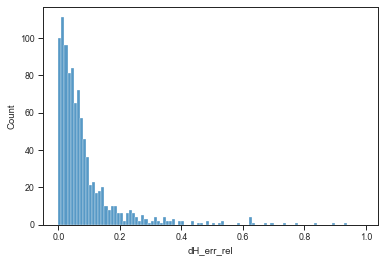

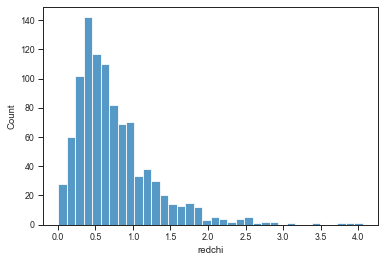

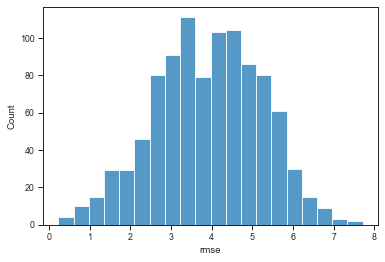

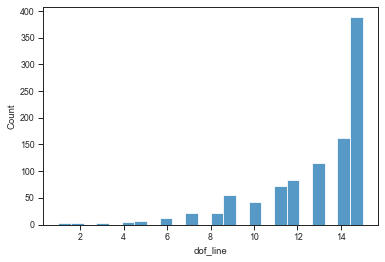

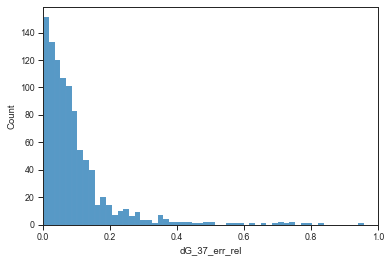

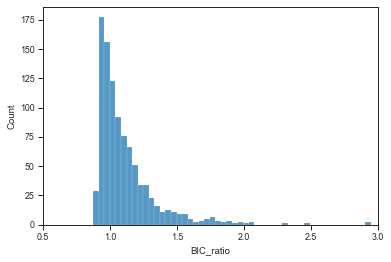

In [44]:
sns.histplot(df.dH_err_rel.sample(1000), bins=np.arange(0, 1, 0.01))
plt.figure()
sns.histplot(df.redchi.sample(1000))

plt.figure()
sns.histplot(df.rmse.sample(1000))

plt.figure()
sns.histplot(df.dof_line.sample(1000))

plt.figure()
sns.histplot(df.dG_37_err_rel.sample(1000))
plt.xlim([0,1])

plt.figure()
sns.histplot(df.BIC_ratio.sample(1000))
plt.xlim([0.5,3])

79.03% of all variants passed filter dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5 & BIC_ratio < 2


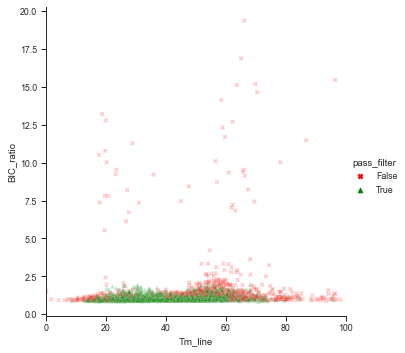

In [77]:
myfilter = "dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5 & BIC_ratio < 2"

mydata = df.sample(5000)
mydata['pass_filter'] = mydata.eval(myfilter)
sns.relplot(data=mydata, x='Tm_line', y='BIC_ratio', 
            hue='pass_filter', style='pass_filter', 
            palette=['r', 'g'], markers=['X', '^'], alpha=.2)
# plt.xlim([0, 2])
plt.xlim([0, 100])
# plt.ylim([0, 100])
# plt.xscale('log')

print('%.2f%% of all variants passed filter %s' % (100 * np.sum(df.eval(myfilter)) / len(df), myfilter))

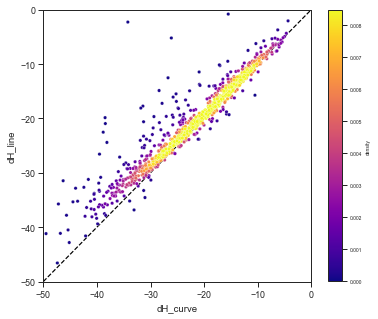

In [271]:
plotting.plot_colored_scatter_comparison(data=df.sample(1000), x='dH_curve', y='dH_line',
                                         lim=[-50, 0])

ValueError: `dataset` input should have multiple elements.

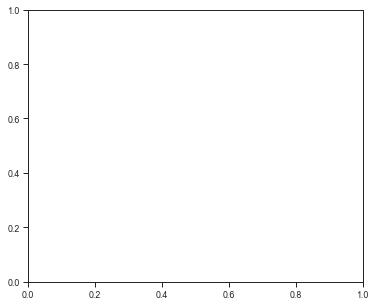

In [272]:
plotting.plot_colored_scatter_comparison(data=df.sample(2000), x='dH_err_rel', y='BIC_ratio',
                                         lim=None)
plt.xlim([-.1, 1])

BNNN3601
dH_err_rel        0.053541
dH_curve         -9.386435
dH_line          -9.917424
dG_37_err_rel     0.126881
Tm_curve         47.682815
Tm_line          45.668845
Tm_err_abs        2.013969
redchi            0.042826
Name: BNNN3601, dtype: float64
BNNN3601: Problem with fitting linear, quadratic and cubic models
dG fitting $\chi^2$ = 0.51, reduced = 0.04, curve fitting $\chi^2$ = 1.03$


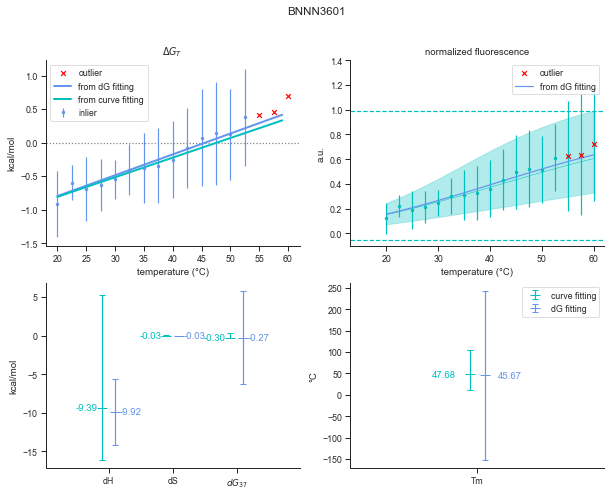

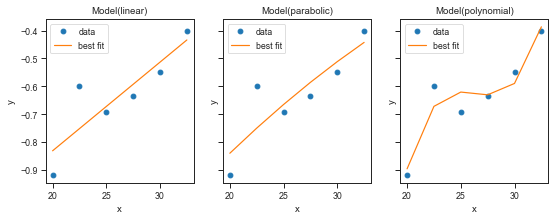

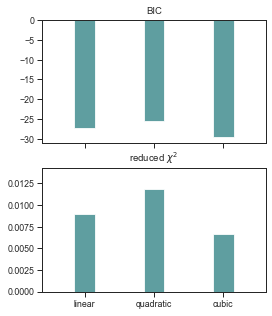

In [93]:
# myfilter = "dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5 & BIC_ratio < 2"
myfilter = "~ (BIC_ratio > 2 & dof_line > 10)"
pass_example = df.query(myfilter).sample(3).index
pass_not_example = df[np.logical_not(df.eval(myfilter))].sample().index

for seqid in pass_not_example:
    print(seqid)
    print(df.loc[seqid, ['dH_err_rel', 'dH_curve', 'dH_line', 'dG_37_err_rel', 'Tm_curve', 'Tm_line', 'Tm_err_abs', 'redchi']])
    dG_fit.plot_dG_fit(seqid, xdata=xdata, dG=dG, dG_se=dG_se, rep=rep, curve=curve)

In [90]:
pass_mask = df.eval("dH_err_rel < 0.25 & Tm_err_abs < 2")

<AxesSubplot:xlabel='BIC_ratio', ylabel='Density'>

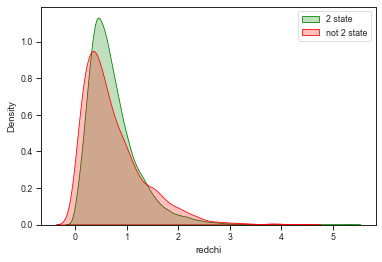

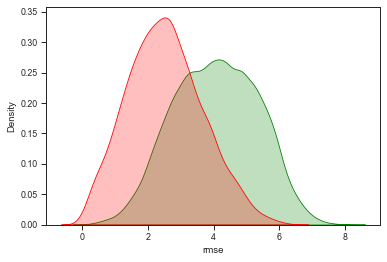

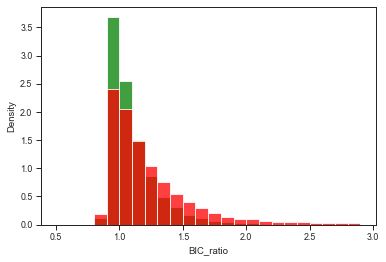

In [75]:
sns.kdeplot(df[pass_mask]['redchi'], color='green', fill=True)
sns.kdeplot(df[~pass_mask]['redchi'], color='red', fill=True)
plt.legend(['2 state', 'not 2 state'])

plt.figure()
sns.kdeplot(df[pass_mask]['rmse'], color='green', fill=True)
sns.kdeplot(df[~pass_mask]['rmse'], color='red', fill=True)

plt.figure()
col = 'BIC_ratio'
sns.histplot(df[pass_mask][col], color='green', bins=np.arange(0.5, 3, 0.1), stat='density')
sns.histplot(df[~pass_mask][col], color='red', bins=np.arange(0.5, 3, 0.1), stat='density')